# Doublets 😎🦒

In [70]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

la.logger.setLevel("INFO")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Simulate data of the two cell types
Data containing only cells 100% of a cell type

In [71]:
n_cells = 100
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim("C" + pd.Series(cell_ids, name="cell"))

n_genes = 100
genes = la.Dim("G" + pd.Series([str(i) for i in range(n_genes)]), name="gene")

celltype_ids = "Ct" + pd.Series(["a", "b"])
celltypes = la.Dim(celltype_ids, name = "celltype")

In [72]:
#Baseline expression, same as before
baseline_expression_value = pd.DataFrame(np.random.normal(scale = 3, size = (celltypes.size, genes.size)), index = celltypes.index, columns = genes.index)
baseline_expression = la.Fixed(baseline_expression_value, label = "baseline_original")

In [73]:
# TEST if we give the simple version where the cells are really simulated as 100% of one cell type works very well
# however in the data our 100% one cell type might be a slight mix (ambiant mRNA? - in theory the ambiant mRNA might come from other cell types too...)
# And we might have few doublets assigned as 100% cells

#proportion_cta = 1.*(np.random.random(cells.size) > 0.5)
#proportion_values = pd.DataFrame(np.transpose((proportion_cta, 1-proportion_cta)), index = cells.index, columns = celltypes.index)
#proportion = la.Fixed(proportion_values, label = "proportion")

In [74]:
real_proportions_value = pd.DataFrame(np.random.dirichlet((0.09,0.09), size = 100), index = cells.index,
                                 columns = celltypes.index)
real_proportions = la.Fixed(real_proportions_value, label = "proportion_real")

In [75]:
real_proportions

proportion_real:  ↦ Fixed [cell (100), celltype (2)]

In [76]:
expression_sim = la.links.vector.Matmul(real_proportions, baseline_expression, label = "expression")
expression_sim.plot()

In [77]:
sim_dist = la.distributions.Normal(expression_sim, la.Fixed(0.1), label = "dist")
sim_dist.plot()

In [78]:
posterior = la.posterior.Posterior(sim_dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

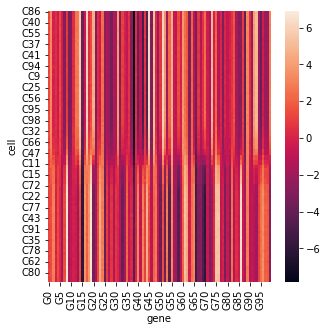

In [79]:
observation_value = posterior.samples[sim_dist].sel(sample=0).to_pandas()
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 5))
cell_order = real_proportions_value[celltype_ids[0]].sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

# 1. Infer baseline
Using the simulated 100% cell type data, infer the baseline gene expression per cell types

In [80]:
baseline_p = la.distributions.Normal(
    loc=la.Parameter(0.0), scale=la.Parameter(1.0, transforms=[la.transforms.Exp()])
)
latent_baseline = la.Latent(
    p=baseline_p, definition=la.Definition([genes, celltypes]), label="baseline"
)
latent_baseline.plot()

In [81]:
observed_proportion_value = (real_proportions_value.T == real_proportions_value.max(axis=1)).T.astype(int).astype(float) #Create a boolean matrix T for the value == to max by row and convert it to int
#sns.scatterplot(
#        x = real_proportions_value[celltype_ids[0]], 
#        y = observed_proportion_value[celltype_ids[0]]
#    )

In [82]:
proportions_observed = la.Fixed(observed_proportion_value, label = "proportion_observed")

In [83]:
expression = la.links.vector.Matmul(latent_baseline, proportions_observed, label = "expression")
expression.plot()

In [84]:
expression_p = la.distributions.Normal(loc = expression)
transcriptome = la.Observation(
    value=observation_value, p=expression_p, definition=la.Definition.from_xr(observation_value), label = "transcriptome"
)

transcriptome.plot()

In [85]:
inference = la.infer.svi.SVI(
    transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)

  0%|                                                                                                         …

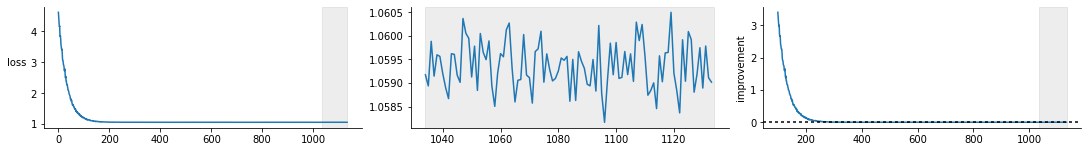

In [86]:
trace = trainer.train(10000)
trace.plot()

In [ ]:
transcriptome_infered = la.posterior.Observed(
    transcriptome, retain_samples={expression.x}
)
transcriptome_infered.sample(100)

In [ ]:
x = np.linspace(-8, 7, 10)
sns.scatterplot(
        x = baseline_expression_value.loc[celltype_ids[0],:], 
        y = transcriptome_infered.samples[expression.x].mean("sample").to_pandas()[celltype_ids[0]]
    )
plt.xlabel('Cta - baseline expression simulated')
plt.ylabel('Cta % - baseline expression inferred')
plt.plot(x, x + 0, linestyle='solid')

# 2. Simulate data with doublets
Add cells ~50/50% of the two cell types

In [89]:
#proportions_value = pd.DataFrame(np.concatenate((np.random.dirichlet((0.3,0.3), size = 50), np.random.dirichlet((50,50), size = 50))), 
#                                 index = cells.index, columns = celltypes.index)
n_new_cells = 50
new_cell_ids = [str(i) for i in range(100, (n_new_cells+100))]
new_cell_ids = "C" + pd.Series(new_cell_ids, name = "cell")

In [90]:
real_newCells_proportions_value = pd.DataFrame(np.random.dirichlet((50,50), size = n_new_cells), index = new_cell_ids, columns= celltypes.index)

In [91]:
real_newCells_proportions_value.index.name

'cell'

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 2., 0.,
        0., 0., 0., 2., 1., 2., 1., 1., 0., 0., 0., 2., 1., 1., 1., 2., 1.,
        1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 2., 1., 2.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 2., 3., 0., 1., 1., 1., 0., 0.,
        2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.40604817, 0.408489  , 0.41092983, 0.41337066, 0.41581148,
        0.41825231, 0.42069314, 0.42313397, 0.4255748 , 0.42801563,
        0.43045646, 0.43289729, 0.43533811, 0.43777894, 0.44021977,
        0.4426606 , 0.44510143, 0.44754226, 0.44998309, 0.45242392,
        0.45486475, 0.45730557, 0.4597464 , 0.46218723, 0.46462806,
        0.46706889, 0.46950972, 0.47195055, 0.47439138, 0.4768322 ,
        0.47927303, 0.48171386, 0.48415469, 0.48659552, 0.48903635,
        0.49147718, 0.49391801, 0.49635884, 0.49879966, 0.50124049,
        0.50368132, 0.50612215, 0.50856298, 0.51100381, 0.51344464,
        0.51588547, 0.5183

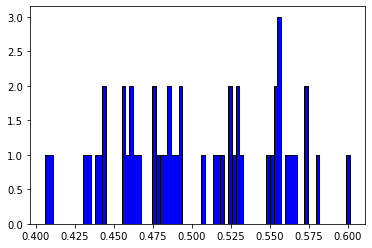

In [92]:
plt.hist(real_newCells_proportions_value.Cta, color = 'blue', edgecolor = 'black',
         bins = 80)

In [93]:
real_newCells_proportions_value.index.name

'cell'

In [94]:
real_proportions_withDoublets_values = pd.concat([real_proportions_value, real_newCells_proportions_value])
real_proportions_withDoublets_values.head()

celltype,Cta,Ctb
cell,,
C0,8.007962e-07,0.999999
C1,8.746143e-11,1.000000
C2,2.228566e-05,0.999978
C3,7.424823e-01,0.257518
C4,2.087734e-05,0.999979


In [95]:
real_proportions_withDoublets = la.Fixed(real_proportions_withDoublets_values, label = "proportion_real")
real_proportions_withDoublets

proportion_real:  ↦ Fixed [cell (150), celltype (2)]

In [96]:
dist_withDoublets = sim_dist.clone()

In [97]:
dist_withDoublets.replace(dist_withDoublets.find("proportion_real"), real_proportions_withDoublets)
dist_withDoublets.find("proportion_real")

proportion_real:  ↦ Fixed [cell (150), celltype (2)]

In [98]:
######dist_withDoublets.replace(la.variables.find_replace.find_optimizable, la.variables.find_replace.replace_optimizable_fixed)

In [99]:
posterior = la.posterior.Posterior(dist_withDoublets)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

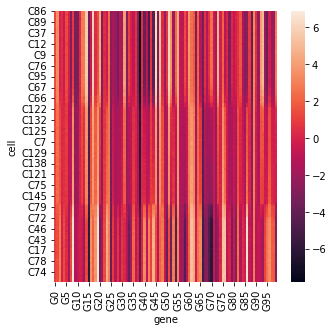

In [100]:
observation_withDoublets_value = posterior.samples[dist_withDoublets].sel(sample=0).to_pandas()
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 5))
cell_order = real_proportions_withDoublets_values[celltype_ids[0]].sort_values().index
sns.heatmap(observation_withDoublets_value.loc[cell_order], ax=ax0)

# 3. Infer proportions
We have the baseline (per gene) per cell type in 100% cells
        transcriptome data containing the same 100% cells and doublets 
We want to try to infer the proportions of each cell types in these cells

In [101]:
n_cells = 150
all_cell_ids = [str(i) for i in range(n_cells)]
all_cells = la.Dim("C" + pd.Series(all_cell_ids, name="cell"))
latent_proportion = la.Latent(
    p=la.distributions.Dirichlet(la.Fixed(np.array([1.,1.]), definition = [celltypes])), 
    definition=la.Definition([all_cells, celltypes]), label="proportion"
)
latent_proportion.plot()

In [132]:
latent_baseline.p.event_dims

set()

In [133]:
baseline_expression_clone = latent_baseline.clone()
baseline_expression_clone.plot()

In [134]:
baseline_expression_clone.p.event_dims

{tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0.,

In [34]:
baseline_expression_clone.replace(la.variables.find_replace.find_optimizable, la.variables.find_replace.replace_optimizable_fixed) 
# replace(what we find is true, by that) 
# Here we replace all the optimizable, so free parameters, by fixed values

In [41]:
expression = la.links.vector.Matmul(latent_proportion, baseline_expression_clone, label="expression")
expression.plot()

In [39]:
all_cells.index

0        C0
1        C1
2        C2
3        C3
4        C4
       ... 
145    C145
146    C146
147    C147
148    C148
149    C149
Name: cell, Length: 150, dtype: object

In [42]:
expression_p = la.distributions.Normal(loc = expression)
transcriptome = la.Observation(
    value=observation_withDoublets_value, p=expression_p, definition=la.Definition.from_xr(observation_withDoublets_value), label = "transcriptome"
)

transcriptome.plot()

In [43]:
inference = la.infer.svi.SVI(
    transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)

  0%|                                                                                                         …

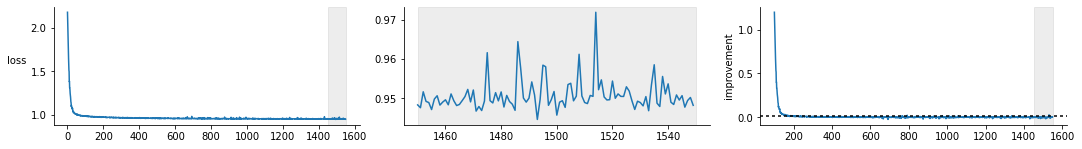

In [44]:
trace = trainer.train(10000)
trace.plot()

In [61]:
transcriptome.find("baseline").p.event_dims

{tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0., 0.]),
 tensor([0.,

In [57]:
transcriptome.run()
transcriptome.find("baseline").likelihood_xr

AssertionError: Some dimensions are not found: (tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.])) vs ('gene', 'celltype')

In [50]:
transcriptome_observed = la.posterior.Observed(
    transcriptome, retain_samples={expression.x}
)
transcriptome_observed.sample(100)

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: None